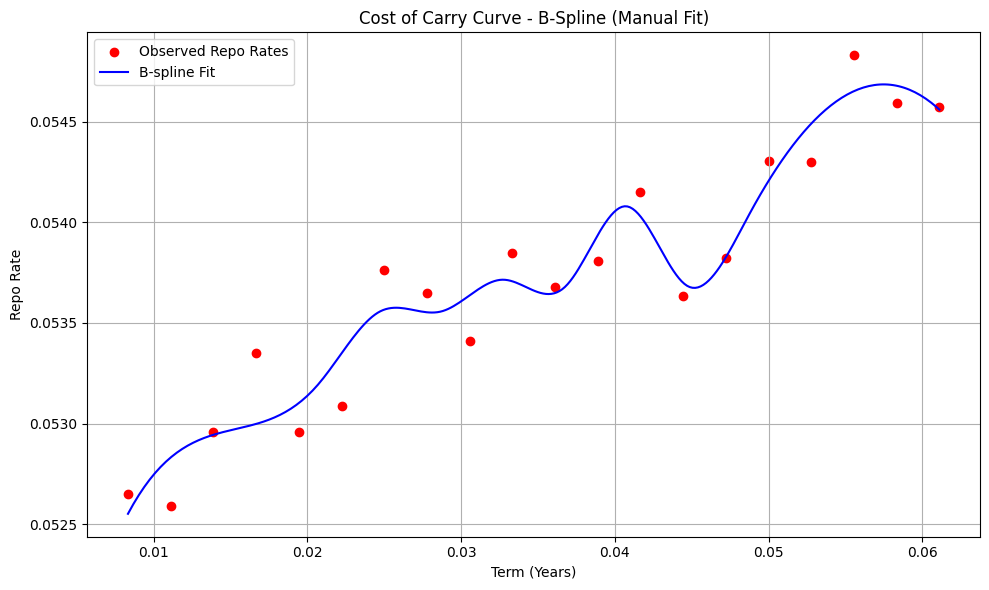

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

# Sample data
np.random.seed(42)
start_date = pd.to_datetime('2024-10-18')
end_dates = pd.date_range(start='2024-10-21', periods=20, freq='D')

base_rate = 0.0525
trend = np.linspace(0, 0.0025, 20)
noise = np.random.normal(0, 0.0003, 20)
repo_rates = base_rate + trend + noise

df = pd.DataFrame({
    'stDt': [start_date] * 20,
    'endDt': end_dates,
    'repo_rt': repo_rates
})

# Calculate 'term' (duration in years)
df['term'] = (df['endDt'] - df['stDt']).dt.days / 360
df.sort_values('term', inplace=True)

x = df['term'].values
y = df['repo_rt'].values

# Degree of the spline
k = 3

# Define number of internal knots
n_internal_knots = 10

# Internal knots safely inside the domain of x
t_internal = np.linspace(x[k], x[-k-1], n_internal_knots)

# Full knot vector: pad with start/end repeated k times
t = np.concatenate((
    [x[0]] * k,
    t_internal,
    [x[-1]] * k
))

# Create basis matrix (design matrix)
from scipy.interpolate import BSpline
from scipy.linalg import lstsq

# Build B-spline basis matrix
def bspline_design_matrix(x, t, k):
    """Creates the B-spline design matrix."""
    n_bases = len(t) - (k + 1)
    basis = np.zeros((len(x), n_bases))
    for i in range(n_bases):
        c = np.zeros(n_bases)
        c[i] = 1
        spline = BSpline(t, c, k)
        basis[:, i] = spline(x)
    return basis

X_design = bspline_design_matrix(x, t, k)

# Solve least squares to get coefficients
coeffs, _, _, _ = lstsq(X_design, y)

# Construct the final B-spline
final_spline = BSpline(t, coeffs, k)

# Evaluate
x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = final_spline(x_vals)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='red', label='Observed Repo Rates')
plt.plot(x_vals, y_vals, color='blue', label='B-spline Fit')
plt.xlabel("Term (Years)")
plt.ylabel("Repo Rate")
plt.title("Cost of Carry Curve - B-Spline (Manual Fit)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
x_query = 0.05  # Example: 18-day term = 18/360 = 0.05 years
y_query = final_spline(x_query)
print(f"Interpolated repo rate for term {x_query:.3f} years: {y_query:.5f}")


Interpolated repo rate for term 0.050 years: 0.05421


In [20]:
x_queries = np.array([0.03, 0.045, 0.06])  # terms in years
y_queries = final_spline(x_queries)

for xq, yq in zip(x_queries, y_queries):
    print(f"Interpolated repo rate for term {xq:.3f} years: {yq:.5f}")


Interpolated repo rate for term 0.030 years: 0.05361
Interpolated repo rate for term 0.045 years: 0.05368
Interpolated repo rate for term 0.060 years: 0.05463


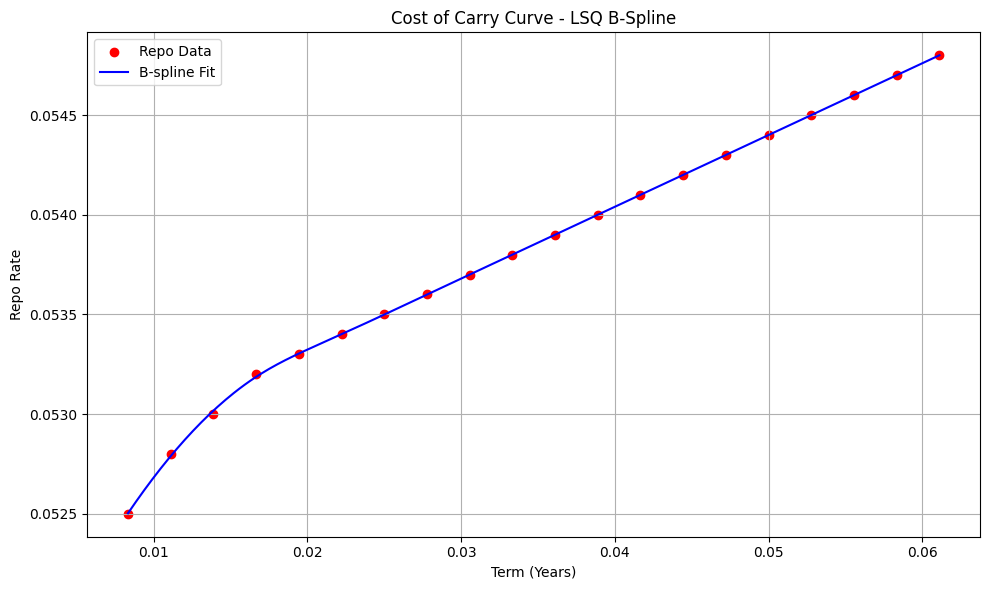

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline

# Sample Data
df = pd.DataFrame({
    'stDt': ['2024-10-18'] * 20,
    'endDt': pd.date_range(start='2024-10-21', periods=20, freq='D'),
    'repo_rt': [
        0.0525, 0.0528, 0.0530, 0.0532, 0.0533, 0.0534, 0.0535, 0.0536, 0.0537, 0.0538,
        0.0539, 0.0540, 0.0541, 0.0542, 0.0543, 0.0544, 0.0545, 0.0546, 0.0547, 0.0548
    ]
})

# Calculate term
df['stDt'] = pd.to_datetime(df['stDt'])
df['term'] = (df['endDt'] - df['stDt']).dt.days / 360
df.sort_values('term', inplace=True)

from scipy.interpolate import LSQUnivariateSpline

# Assume x and y are sorted and ready
x = df['term'].values
y = df['repo_rt'].values
k = 3  # cubic

# Choose some internal knots (not too close to the ends)
n_knots = 10
t_internal = np.linspace(x[k], x[-k-1], n_knots)

# Fit spline using LSQUnivariateSpline
spline = LSQUnivariateSpline(x, y, t_internal, k=k)

# Evaluate
x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = spline(x_vals)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='red', label='Repo Data')
plt.plot(x_vals, y_vals, color='blue', label='B-spline Fit')
plt.xlabel("Term (Years)")
plt.ylabel("Repo Rate")
plt.title("Cost of Carry Curve - LSQ B-Spline")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


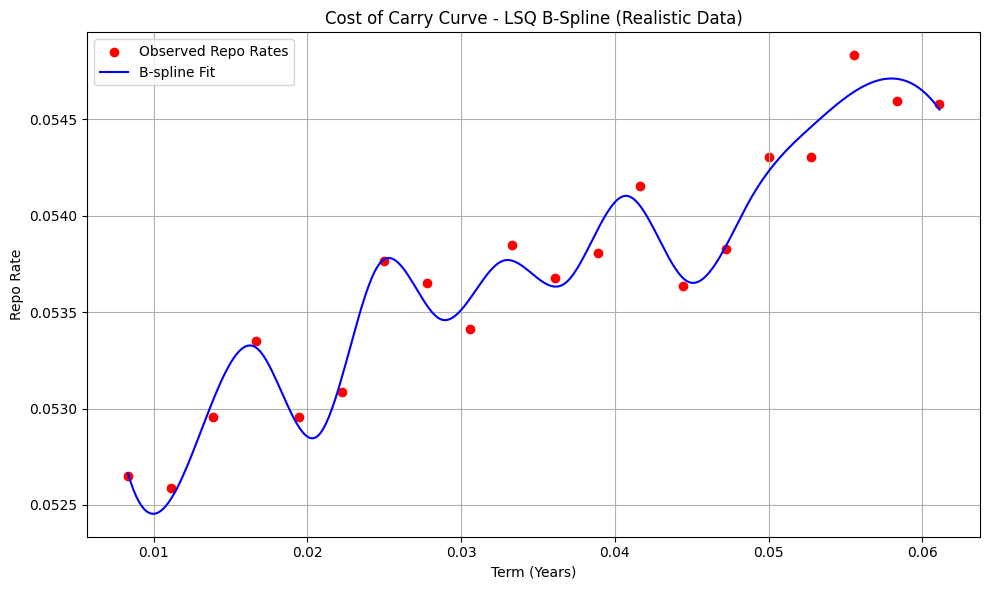


Formatted Data Used:

      stDt      endDt     term  repo_rt
2024-10-18 2024-10-21 0.008333 0.052649
2024-10-18 2024-10-22 0.011111 0.052590
2024-10-18 2024-10-23 0.013889 0.052957
2024-10-18 2024-10-24 0.016667 0.053352
2024-10-18 2024-10-25 0.019444 0.052956
2024-10-18 2024-10-26 0.022222 0.053088
2024-10-18 2024-10-27 0.025000 0.053763
2024-10-18 2024-10-28 0.027778 0.053651
2024-10-18 2024-10-29 0.030556 0.053412
2024-10-18 2024-10-30 0.033333 0.053847
2024-10-18 2024-10-31 0.036111 0.053677
2024-10-18 2024-11-01 0.038889 0.053808
2024-10-18 2024-11-02 0.041667 0.054152
2024-10-18 2024-11-03 0.044444 0.053637
2024-10-18 2024-11-04 0.047222 0.053825
2024-10-18 2024-11-05 0.050000 0.054305
2024-10-18 2024-11-06 0.052778 0.054301
2024-10-18 2024-11-07 0.055556 0.054831
2024-10-18 2024-11-08 0.058333 0.054596
2024-10-18 2024-11-09 0.061111 0.054576


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LSQUnivariateSpline

# 1. Generate Sample Data
np.random.seed(42)  # For reproducibility

# Generate 20 days from a start date
start_date = pd.to_datetime('2024-10-18')
end_dates = pd.date_range(start='2024-10-21', periods=20, freq='D')

# Create wiggly repo rates around a trend
base_rate = 0.0525
trend = np.linspace(0, 0.0025, 20)  # Slight upward trend
noise = np.random.normal(0, 0.0003, 20)  # Small random fluctuation
repo_rates = base_rate + trend + noise

# Build DataFrame
df = pd.DataFrame({
    'stDt': [start_date] * 20,
    'endDt': end_dates,
    'repo_rt': repo_rates
})

# 2. Calculate Term (in years)
df['term'] = (df['endDt'] - df['stDt']).dt.days / 360
df.sort_values('term', inplace=True)

# 3. Prepare Variables
x = df['term'].values
y = df['repo_rt'].values
k = 3  # Cubic spline

# Choose internal knots (not too close to the ends)
n_knots = 10
t_internal = np.linspace(x[k], x[-k-1], n_knots)

# 4. Fit Spline
spline = LSQUnivariateSpline(x, y, t_internal, k=k)

# 5. Evaluate Spline
x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = spline(x_vals)

# 6. Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='red', label='Observed Repo Rates')
plt.plot(x_vals, y_vals, color='blue', label='B-spline Fit')
plt.xlabel("Term (Years)")
plt.ylabel("Repo Rate")
plt.title("Cost of Carry Curve - LSQ B-Spline (Realistic Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print data
print("\nFormatted Data Used:\n")
print(df[['stDt', 'endDt', 'term', 'repo_rt']].to_string(index=False))


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline

# Sample repo trade data with 20 rows
data = {
    'pres_dt': ['2024-10-18'] * 20,
    'stDt': ['2024-10-18'] * 20,
    'endDt': pd.date_range(start='2024-10-21', periods=20, freq='D').strftime('%Y-%m-%d'),
    'repo_rt': [
        0.0525, 0.0528, 0.0530, 0.0532, 0.0533, 0.0534, 0.0535, 0.0536, 0.0537, 0.0538,
        0.0539, 0.0540, 0.0541, 0.0542, 0.0543, 0.0544, 0.0545, 0.0546, 0.0547, 0.0548
    ],
    'stAmt': [
        10e6, 12e6, 15e6, 17e6, 14e6, 11e6, 13e6, 9e6, 10e6, 12.5e6,
        9.5e6, 10.5e6, 11.5e6, 14.5e6, 13.5e6, 16e6, 17e6, 15.5e6, 14.5e6, 13e6
    ]
}

df = pd.DataFrame(data)

In [8]:

# Convert to datetime
df['stDt'] = pd.to_datetime(df['stDt'])
df['endDt'] = pd.to_datetime(df['endDt'])

# Calculate term in years using 360-day convention
df['term'] = (df['endDt'] - df['stDt']).dt.days / 360

# Sort by term
df.sort_values('term', inplace=True)

# Prepare inputs for B-spline
x = df['term'].values
y = df['repo_rt'].values
k = 3  # Cubic B-spline
t = np.linspace(x.min(), x.max(), len(x) + k + 1 - k)

In [11]:

# Fit spline
spline = make_lsq_spline(x, y, t, k)




ValueError: Out of bounds w/ x = [0.00833333 0.01111111 0.01388889 0.01666667 0.01944444 0.02222222
 0.025      0.02777778 0.03055556 0.03333333 0.03611111 0.03888889
 0.04166667 0.04444444 0.04722222 0.05       0.05277778 0.05555556
 0.05833333 0.06111111].

In [12]:
# Evaluate spline
x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = spline(x_vals)

NameError: name 'spline' is not defined

In [ ]:

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='red', label='Repo Data')
plt.plot(x_vals, y_vals, color='blue', label='B-spline Fit')
plt.xlabel("Term (Years)")
plt.ylabel("Repo Rate")
plt.title("B-spline Interpolated Cost of Carry Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.interpolate import make_lsq_spline
import matplotlib.pyplot as plt

In [2]:

# ----------------------------
# STEP 1: Dummy Data for Repo
# ----------------------------
data = {
    'pres_dt': [datetime(2024, 10, 18)] * 6,
    'stDt': pd.to_datetime(['2024-10-18'] * 6),
    'endDt': pd.to_datetime(['2024-10-25', '2024-10-28', '2024-10-31', '2024-11-03', '2024-11-10', '2024-11-17']),
    'repo_rt': [0.0520, 0.0530, 0.0540, 0.0555, 0.0560, 0.0565],
    'stAmt': [30e6, 25e6, 20e6, 40e6, 22e6, 18e6]
}
newTrdDf = pd.DataFrame(data)


In [3]:
newTrdDf

,pres_dt,stDt,endDt,repo_rt,stAmt
0,2024-10-18,2024-10-18,2024-10-25,0.0520,30000000.0
1,2024-10-18,2024-10-18,2024-10-28,0.0530,25000000.0
2,2024-10-18,2024-10-18,2024-10-31,0.0540,20000000.0
3,2024-10-18,2024-10-18,2024-11-03,0.0555,40000000.0
4,2024-10-18,2024-10-18,2024-11-10,0.0560,22000000.0
5,2024-10-18,2024-10-18,2024-11-17,0.0565,18000000.0


In [5]:
# ----------------------------
# STEP 2: Calculate Term in Years
# ----------------------------
newTrdDf['term_days'] = (newTrdDf['endDt'] - newTrdDf['stDt']).dt.days
newTrdDf['term_years'] = newTrdDf['term_days'] / 360


# Sort by term
df_sorted = newTrdDf.sort_values(by='term_years')


In [ ]:

# ----------------------------
# STEP 3: B-Spline Interpolation
# ----------------------------
x = df_sorted['term_years'].values
y = df_sorted['repo_rt'].values
k = 3  # cubic spline

# Set knot vector (t)
n = len(x)
if n >= k + 1:
    # Padding knots on ends
    t = np.concatenate((
        [x[0]] * k,
        np.linspace(x[0], x[-1], n - k + 1),
        [x[-1]] * k
    ))

    # Fit B-spline
    spl = make_lsq_spline(x, y, t, k)

    # Evaluate spline
    x_vals = np.linspace(x[0], x[-1], 200)
    y_vals = spl(x_vals)

    # ----------------------------
    # STEP 4: Plot
    # ----------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'o', label='Actual Repo Rates')
    plt.plot(x_vals, y_vals, '-', label='B-Spline Curve', color='darkgreen')
    plt.xlabel("Repo Term (Years)")
    plt.ylabel("Repo Rate")
    plt.title("Repo Term Structure using B-Spline Interpolation")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough points to fit a B-spline.")
